Neural network to get galaxy type, Here only two types. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression

Getting the data. It are currently 16 fields. 

In [2]:
cutouts1=np.load("stripe82_1_ell_spiral_im.npy")
cutouts2=np.load("stripe82_2_ell_spiral_im.npy")
cutouts3=np.load("stripe82_3_ell_spiral_im.npy")
cutouts4=np.load("stripe82_4_ell_spiral_im.npy")
cutouts5=np.load("stripe82_5_ell_spiral_im.npy")
cutouts6=np.load("stripe82_6_ell_spiral_im.npy")
cutouts7=np.load("stripe82_7_ell_spiral_im.npy")
cutouts8=np.load("stripe82_8_ell_spiral_im.npy")
cutouts9=np.load("stripe82_9_ell_spiral_im.npy")
cutouts10=np.load("stripe82_10_ell_spiral_im.npy")
cutouts11=np.load("stripe82_11_ell_spiral_im.npy")
cutouts12=np.load("stripe82_12_ell_spiral_im.npy")
cutouts13=np.load("stripe82_13_ell_spiral_im.npy")
cutouts14=np.load("stripe82_14_ell_spiral_im.npy")
cutouts15=np.load("stripe82_15_ell_spiral_im.npy")
cutouts16=np.load("stripe82_16_ell_spiral_im.npy")
cutouts17=np.load("stripe82_17_ell_spiral_im.npy")
cutouts18=np.load("stripe82_18_ell_spiral_im.npy")
cutouts19=np.load("stripe82_19_ell_spiral_im.npy")
cutouts20=np.load("stripe82_20_ell_spiral_im.npy")
cutouts21=np.load("stripe82_21_ell_spiral_im.npy")
cutouts22=np.load("stripe82_22_ell_spiral_im.npy")
cutouts23=np.load("stripe82_23_ell_spiral_im.npy")
cutouts24=np.load("stripe82_24_ell_spiral_im.npy")
print(cutouts1.shape)
df1=pd.read_csv("stripe82_1_ell_spiral_table.csv")
df2=pd.read_csv("stripe82_2_ell_spiral_table.csv")
df3=pd.read_csv("stripe82_3_ell_spiral_table.csv")
df4=pd.read_csv("stripe82_4_ell_spiral_table.csv")
df5=pd.read_csv("stripe82_5_ell_spiral_table.csv")
df6=pd.read_csv("stripe82_6_ell_spiral_table.csv")
df7=pd.read_csv("stripe82_7_ell_spiral_table.csv")
df8=pd.read_csv("stripe82_8_ell_spiral_table.csv")
df9=pd.read_csv("stripe82_9_ell_spiral_table.csv")
df10=pd.read_csv("stripe82_10_ell_spiral_table.csv")
df11=pd.read_csv("stripe82_11_ell_spiral_table.csv")
df12=pd.read_csv("stripe82_12_ell_spiral_table.csv")
df13=pd.read_csv("stripe82_13_ell_spiral_table.csv")
df14=pd.read_csv("stripe82_14_ell_spiral_table.csv")
df15=pd.read_csv("stripe82_15_ell_spiral_table.csv")
df16=pd.read_csv("stripe82_16_ell_spiral_table.csv")
df17=pd.read_csv("stripe82_17_ell_spiral_table.csv")
df18=pd.read_csv("stripe82_18_ell_spiral_table.csv")
df19=pd.read_csv("stripe82_19_ell_spiral_table.csv")
df20=pd.read_csv("stripe82_20_ell_spiral_table.csv")
df21=pd.read_csv("stripe82_21_ell_spiral_table.csv")
df22=pd.read_csv("stripe82_22_ell_spiral_table.csv")
df23=pd.read_csv("stripe82_23_ell_spiral_table.csv")
df24=pd.read_csv("stripe82_24_ell_spiral_table.csv")
print(df1.columns)

(43, 43, 1, 168)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image'],
      dtype='object')


Now I built the function to combine the four numpy arrays.

In [3]:
#combines numpy arrays of 4d shape, same shape first 3, last variable
def comb_nump_4d(input_list):
    l=0
    for i in range(len(input_list)):
        l+=input_list[i].shape[3]
    combined=np.zeros((input_list[0].shape[0],input_list[0].shape[1],input_list[0].shape[2],l))
    l=0
    for i in range(len(input_list)):
        combined[:,:,:,l:l+input_list[i].shape[3]]=input_list[i]
        l+=input_list[i].shape[3]  
    return combined

Combining the images. 

In [4]:
cutout_lists=[cutouts1,cutouts2,cutouts3,cutouts4,cutouts5,cutouts6,cutouts7,cutouts8,cutouts9,cutouts10,cutouts11,cutouts12,cutouts13,cutouts14,cutouts15,cutouts16,cutouts17,cutouts18,cutouts19,cutouts20,cutouts21,cutouts22,cutouts23,cutouts24]
cutouts=comb_nump_4d(cutout_lists)

Now combining the data frames with the classfications and more meta data. 

In [5]:
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20,df21,df22,df23,df24],ignore_index=True)
print(df1.head(),df.head(),df24.tail(),df.tail())

   Unnamed: 0  index                objid         ra       dec  psfMag_u  \
0           0      1  1237663237128388701  50.130513 -1.228488  22.01211   
1           1    123  1237666299481817102  50.160628 -1.035026  19.01124   
2           2    140  1237663237128388949  50.167304 -1.241885  22.36878   
3           3    458  1237666300018557091  50.006004 -0.495751  21.98376   
4           4    110  1237663238739067202  50.387910  0.198944  21.86834   

   psfMag_g  psfMag_r  psfMag_i  psfMag_z  ...   p_mg  p_el_debiased  \
0  20.06700  18.86854  18.35853  17.93478  ...  0.032          0.935   
1  17.46116  16.85288  16.54355  16.19304  ...  0.000          0.971   
2  20.17246  18.94735  18.44240  17.99196  ...  0.000          0.964   
3  19.93291  18.73658  18.31895  17.89719  ...  0.000          0.893   
4  19.78908  18.63620  18.16101  17.63892  ...  0.018          0.755   

   p_cs_debiased  spiral  elliptical  uncertain  image      pixel_x  \
0          0.000       0           1   

Has worked, now looking on classes. 

In [6]:
print(df.spiral.value_counts())

1    3260
0    1218
Name: spiral, dtype: int64


Somewhat inbalanced, clearly more spirals than ellipctical galaxies.
 
Now adding columns to data frame that also other algorithms can work on it. 

In [7]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)        

/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

      Unnamed: 0  index                objid         ra       dec  psfMag_u  \
0              0      1  1237663237128388701  50.130513 -1.228488  22.01211   
1              1    123  1237666299481817102  50.160628 -1.035026  19.01124   
2              2    140  1237663237128388949  50.167304 -1.241885  22.36878   
3              3    458  1237666300018557091  50.006004 -0.495751  21.98376   
4              4    110  1237663238739067202  50.387910  0.198944  21.86834   
...          ...    ...                  ...        ...       ...       ...   
4473         211    347  1237663543697014949   2.404652  0.348459  20.32222   
4474         212    504  1237657191979876531   2.054626  0.791835  21.11070   
4475         213    332  1237657192516812954   2.324499  1.216724  21.72815   
4476         214    184  1237663278465745022   2.496867  0.914971  21.07331   
4477         215    137  1237657192516681848   2.033025  1.228735  21.61452   

      psfMag_g  psfMag_r  psfMag_i  psfMag_z  ...  

/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_25692/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

In [8]:
print(df.columns[51],df.columns[1899])

0 1848


Now starting with torch spefifics. 

In [9]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [10]:
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)
print(feature_test)

shape of image train data
(2686, 1, 43, 43)
           0         1         2         3         4          5          6     \
1848  -0.346549 -0.608555 -1.468688  0.796124 -1.075122  -0.827261  -1.845495   
913    2.520581  1.574871  3.212093  2.876020  2.365186   3.635672   3.076731   
2621   0.191485  0.536225  0.105229  0.606763  1.016677  -0.370273   0.258619   
1213   0.202705  0.209904  0.871823  1.679326  0.538889  -0.631129   0.006117   
4348  -0.021553 -2.380721 -0.081026  0.120534 -0.742695  -0.325910  -1.040966   
...         ...       ...       ...       ...       ...        ...        ...   
4118  -0.240284  0.729252  0.211816  0.105143  0.632508   0.907785  -0.050688   
2284   1.242518  0.467129  1.143578  0.858799  0.565452  -0.510901   2.245279   
1408  11.518291  9.444175  7.835649  7.611922  9.259028  11.052518  10.223943   
2481   1.557697  0.528282  0.210981  0.699141  0.805156   1.023949   0.291015   
2641   3.992273  5.000192  6.258675  7.220315  8.457665   8.66395

Now creating multiple entries for each by mirroring and rotations. First make image of the first without. 

(2686, 1, 43, 43)


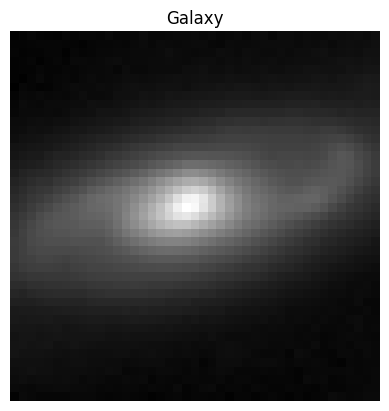

In [15]:
print(image_train.shape)
plt.axis('off')
plt.title("Galaxy normal")
plt.imshow(image_train[0,0,:,:]**0.5,cmap=cm.gray, interpolation='nearest')

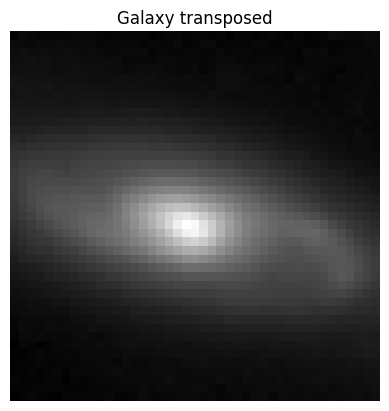

In [17]:
plt.axis('off')
plt.title("Galaxy x mirrored)
plt.imshow(np.flip(image_train[0,0,:,:],0)**0.5,cmap=cm.gray, interpolation='nearest')

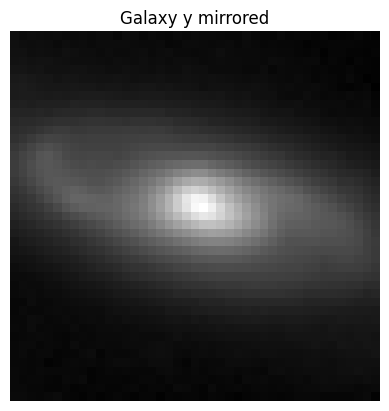

In [19]:
plt.axis('off')
plt.title("Galaxy y mirrored")
plt.imshow(np.flip(image_train[0,0,:,:],1)**0.5,cmap=cm.gray, interpolation='nearest')

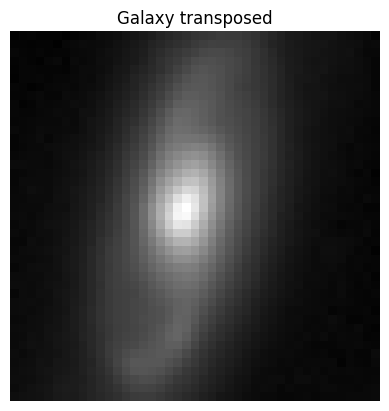

In [16]:
plt.axis('off')
plt.title("Galaxy transposed")
plt.imshow(image_train[0,0,:,:].T**0.5,cmap=cm.gray, interpolation='nearest')

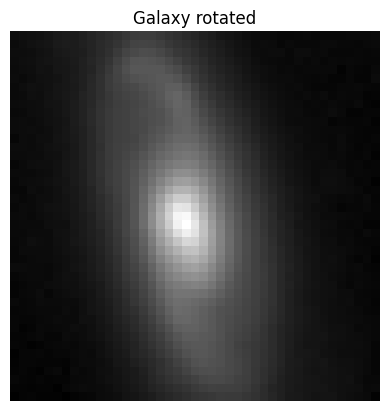

In [24]:
plt.axis('off')
plt.title("Galaxy rotated")
plt.imshow(np.rot90(image_train[0,0,:,:], k=1, axes=(0, 1))**0.5,cmap=cm.gray, interpolation='nearest')


Thus getting all 7 other apparences means 3 rotations on original and flip on original 3 rotations on it. That are in total 8. 

In [25]:
def get_rot_mirror_square(dat):
    if dat.shape[0]!=dat.shape[1]:
        print("Data is not a square")
    else:
        res=np.zeros((8,dat.shape[0],dat.shape[1]))
        res[0,:,:]=dat
        res[4,:,:]=np.flip(dat,0)
        for i in range(3):
            res[1+i,:,:]=np.rot90(dat,k=i+1,axes=(0,1))
            res[5+i,:,:]=np.rot90(res[4,:,:],k=i+1,axes=(0,1))
        return res    

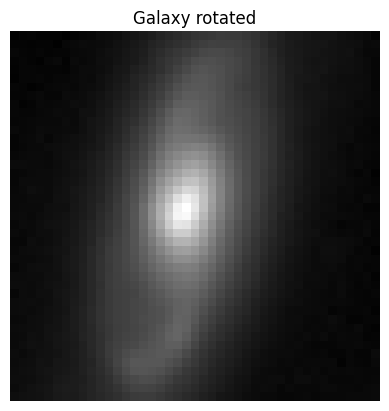

In [36]:
all_rots=get_rot_mirror_square(image_train[0,0,:,:])

plt.axis('off')
plt.title("Galaxy rotated")
plt.imshow(all_rots[7,:,:]**0.5,cmap=cm.gray, interpolation='nearest')

All work.

In [37]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

In [38]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [39]:
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)


In [40]:
BATCH_SIZE=32

In [41]:
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())


In [42]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)

Perceptron network. 4 layers tried. 

In [43]:
#now 4 layers 
#two output options only 
class BinaryClassification4(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification4, self).__init__()
        self.fc1 = nn.Linear(num_features, 300)
        self.fc2 = nn.Linear(300, 100)  
        self.fc3 = nn.Linear(100, 30)        
        self.fc4 = nn.Linear(30, 10)   
        self.fc5 = nn.Linear(10, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))        
        x = torch.sigmoid(self.fc5(x))
        return (x)

Now trying smaller networks, likely the data is too noisy and not large enough that the standard amount works.

In [44]:
#now 1 layers outside of output layer 
#two output options only 
class BinaryClassification1(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification1, self).__init__()
        self.fc1 = nn.Linear(num_features, 100)  
        self.fc2 = nn.Linear(100, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))       
        x = torch.sigmoid(self.fc2(x))
        return (x)

In [45]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 1849

In [46]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect stats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

In [47]:
model0 =BinaryClassification4(NUM_FEATURES)
model0.to(device)
print(model0)


BinaryClassification4(
  (fc1): Linear(in_features=1849, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)


In [48]:
loss_stats_m = {
    'train': [], 'test': []
}
torch_fit(model0,train_loader,test_loader,20,32,0.1,loss_stats_m)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 73.36483 | Test Loss: 70.92634
Epoch 002: | Train Loss: 74.04762 | Test Loss: 70.92634
Epoch 003: | Train Loss: 74.05506 | Test Loss: 70.92634
Epoch 004: | Train Loss: 74.05010 | Test Loss: 70.92634
Epoch 005: | Train Loss: 74.05258 | Test Loss: 70.92634
Epoch 006: | Train Loss: 74.05258 | Test Loss: 70.92634
Epoch 007: | Train Loss: 74.04018 | Test Loss: 70.92634
Epoch 008: | Train Loss: 74.04762 | Test Loss: 70.92634
Epoch 009: | Train Loss: 74.04762 | Test Loss: 70.92634
Epoch 010: | Train Loss: 74.05506 | Test Loss: 70.92634
Epoch 011: | Train Loss: 74.05258 | Test Loss: 70.92634
Epoch 012: | Train Loss: 74.05506 | Test Loss: 70.92634
Epoch 013: | Train Loss: 74.04266 | Test Loss: 70.92634
Epoch 014: | Train Loss: 74.05258 | Test Loss: 70.92634
Epoch 015: | Train Loss: 74.06250 | Test Loss: 70.92634
Epoch 016: | Train Loss: 74.05506 | Test Loss: 70.92634
Epoch 017: | Train Loss: 74.05258 | Test Loss: 70.92634
Epoch 018: | Train Loss: 74.04514 | Test Loss: 7

In [49]:
m_test=pred_torch(model0,test_loader)
m_train=pred_torch(model0,train_loader_pred)
print(m_test)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [50]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [51]:
# 2 116 12 | 116 182 test 71 71 | 76 130 
# 4  46 82 | 21 277 test  30 48 | 18 188
# seems to restart at each trail 
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("4 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)
#some have 124 4 18 280 in train, test: 70 8 32 174
#now 16 samples, 40 epochs, train  256 38 81 711 
#now with 200 got into one sided train 0 454 0 1175

4 layer perceptron
train
[[ 697    0]
 [1989    0]]
test
[[ 521    0]
 [1271    0]]


In [52]:
#now 1 layers outside of output layer 
#two output options only 
class BinaryClassification1(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification1, self).__init__()
        self.fc1 = nn.Linear(num_features, 100)  
        self.fc2 = nn.Linear(100, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))       
        x = torch.sigmoid(self.fc2(x))
        return (x)

In [53]:
#2 layers outside of output layer 
#two output options only 
class BinaryClassification2(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification2, self).__init__()
        self.fc1 = nn.Linear(num_features, 400)  
        self.fc2 = nn.Linear(400, 50)         
        self.fc3 = nn.Linear(50, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))   
        x = torch.relu(self.fc2(x))          
        x = torch.sigmoid(self.fc3(x))
        return (x)

In [54]:
#now 1 layers outside of output layer 
#two output options only 
class BinaryClassification0(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification0, self).__init__()
        self.fc1 = nn.Linear(num_features, 1)          
    def forward(self, x):   
        x = torch.sigmoid(self.fc1(x))
        return (x)

Now single layer in between sigmnoid. 

In [55]:
#if that redone new stars with potentailly better fit 
model0b =BinaryClassification2(NUM_FEATURES)
model0b.to(device)
print(model0b)


BinaryClassification2(
  (fc1): Linear(in_features=1849, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [56]:
loss_stats_mb = {
    'train': [], 'test': []
}
torch_fit(model0b,train_loader,test_loader,20,32,0.01,loss_stats_mb)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.46424 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.93750 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.94990 | Test Loss: 2

In [57]:
mb_test=pred_torch(model0b,test_loader)
mb_train=pred_torch(model0b,train_loader_pred)
#20 has 0.7267008423805237 0.7267008423805237
#40 has 0.7171279788017273 0.7171279788017273
#80 has 0.7857266664505005 0.7857266664505005 seems more fundamental problem 
print(min(mb_test),max(mb_test))
conf_test_mb=conf_for_torch(mb_test,target_test)
conf_train_mb=conf_for_torch(mb_train,target_train)
print("1 layer perceptron")
print("train")
print(conf_train_mb)
print("test")
print(conf_test_mb)

1.0 1.0
1 layer perceptron
train
[[   0  697]
 [   0 1989]]
test
[[   0  521]
 [   0 1271]]


It still does not work in several attempts, both withn 1 layer and 0 layer, which should be just logistic, but it cannot be logistic because logistic sklearn does work. 0 layer gets high loss 27 or larger in all trials (means nearly all probabalities are exactly 0 or 1). 1 layer gets maybe more often a constant one of about 0.7 probability.

Text(0, 0.5, 'BCE loss')

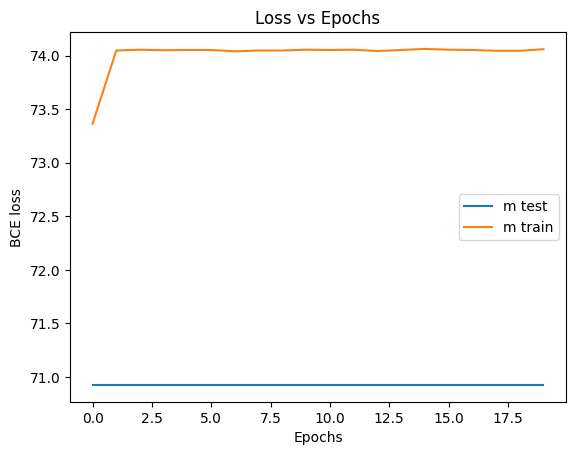

In [58]:
plt.plot(loss_stats_m['test'],label='m test')
plt.plot(loss_stats_m['train'],label='m train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

Does not work reliable for four loaded data sets, but sometimes works at least in train. 
Maybe better with 9/16 loaded data sets still many problems.

In [59]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

In [61]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)
#16 test was 247 47 \ 55 737
#24 test  440 61  \ 81 1210

confusion matrix xgboost train
[[ 697    0]
 [   0 1989]]
confusion matrix xgboost test
[[ 440   81]
 [  61 1210]]


Xgboost works at approximate already with 4 data sets when networks have problems. Now with larger data set, multilayer perceptron is about as good as it in test.  

In [62]:
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)
#16 test  169 125 \ 245 547
#24 test  276 245 \ 349 922 gets worse in the minor class,better in the main 

confusion matrix logistic regression train
[[ 694    3]
 [   2 1987]]
confusion matrix logistic regression test
[[276 245]
 [349 922]]


Logistic works less good as xgboost and does not improve much with more data. Means that wrong features are fit then. Both should improve with regularization. 

In [64]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [65]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.47327351e-01 2.53808059e-03
  2.34367040e-01]
 [3.00000000e-04 1.00000000e+00 9.45355191e-01 2.47019513e-03
  2.41076320e-01]
 [1.00000000e-03 1.00000000e+00 9.44574551e-01 2.51625956e-03
  2.40562264e-01]
 [3.00000000e-03 1.00000000e+00 9.46630308e-01 2.43742859e-03
  2.42179244e-01]
 [1.00000000e-02 1.00000000e+00 9.43793911e-01 2.47923426e-03
  2.40008479e-01]
 [3.00000000e-02 1.00000000e+00 9.48437500e-01 2.52016124e-03
  2.42220570e-01]
 [1.00000000e-01 1.00000000e+00 9.

In [66]:
np.savetxt("xgb_24sets_gal-type_v1.txt",stats_xgb)

In [178]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}") #does not always converge but are cases which are certainly not useful ones
        xc1=LogisticRegression(max_iter=10000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [188]:
regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
print(regs)

[1e-10, 3e-09, 1e-08, 3e-08, 1e-07, 3e-07, 1e-06, 3e-06, 1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]


In [189]:
#could still add more on start but best now included
regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))

doing l2 regularization 1e-10
doing l2 regularization 3e-09
doing l2 regularization 1e-08
doing l2 regularization 3e-08
doing l2 regularization 1e-07
doing l2 regularization 3e-07
doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 10


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 30


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 100
[[0.00000e+00 8.38090e-01 8.45250e-01 5.78500e-01 5.69640e-01]
 [0.00000e+00 8.53040e-01 8.56510e-01 5.21440e-01 5.12870e-01]
 [0.00000e+00 8.61520e-01 8.60660e-01 4.89280e-01 4.81160e-01]
 [0.00000e+00 8.62880e-01 8.56820e-01 4.66470e-01 4.60050e-01]
 [0.00000e+00 8.60110e-01 8.55820e-01 4.51730e-01 4.49340e-01]
 [0.00000e+00 8.58250e-01 8.52290e-01 4.42930e-01 4.46090e-01]
 [0.00000e+00 8.57810e-01 8.55790e-01 4.34390e-01 4.46990e-01]
 [0.00000e+00 8.59950e-01 8.55790e-01 4.25200e-01 4.52560e-01]
 [0.00000e+00 8.57810e-01 8.55790e-01 4.34390e-01 4.46990e-01]
 [0.00000e+00 8.59950e-01 8.55790e-01 4.25200e-01 4.52560e-01]
 [1.00000e-05 8.66400e-01 8.48630e-01 4.12090e-01 4.69020e-01]
 [3.00000e-05 8.70600e-01 8.45690e-01 3.96490e-01 5.05490e-01]
 [1.00000e-04 8.79300e-01 8.43830e-01 3.72370e-01 5.67810e-01]
 [3.00000e-04 8.94970e-01 8.45780e-01 3.38760e-01 6.08610e-01]
 [1.00000e-03 9.23010e-01 8.35510e-01 2.81570e-01 6.94040e-01]
 [3.00000e-03 9.58940e-01 8

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now plotting both, first f1 score. 

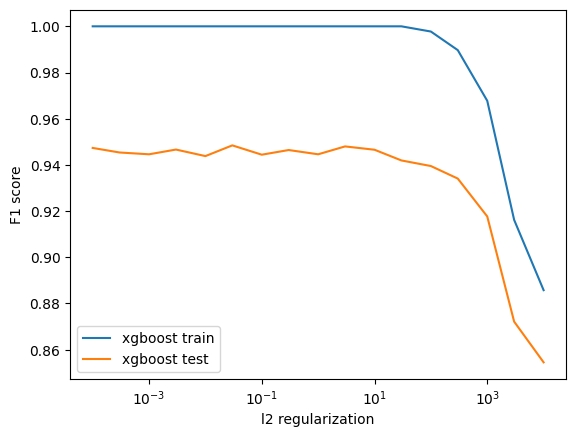

In [68]:
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
#plt.plot(stats_log[0],stats_log[1],label='logistic train')
#plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

Then log loss. 

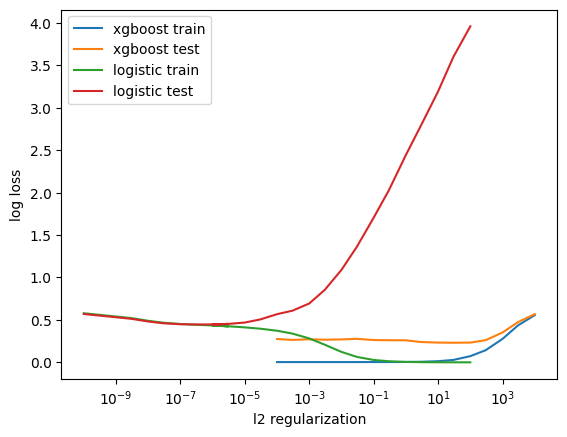

In [192]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
#plt.plot(stats_log[0],stats_log[3],label='logistic train')
#plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")

Xgboost is clearly better. It is in the not so much data limit where adding regularziation is not clearly improving test at F1 score. Below I zoom into log loss to see whether there is a minimum.

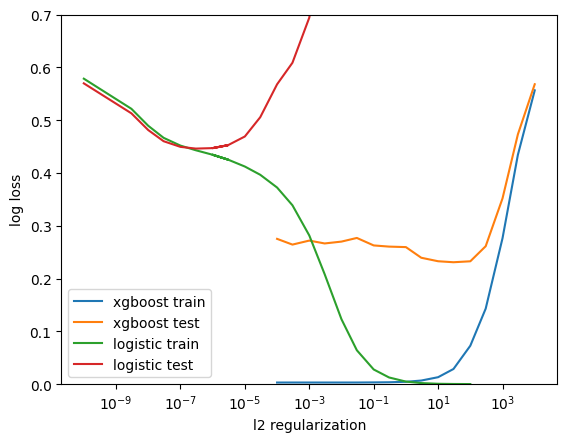

In [193]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.ylim(0,0.7)
plt.xscale("log")

There is one now at not extactly the same position as the local maximum in the F1 score. For linear there is also a minimum now visible, a clearly worse, but still better than a constant probability, similar as to xgboost the local shifts compared to the local maximum in the F1 score.  That shifting is bot ideal, I should likely add rotations mirrorring versions for fitting in any case but is unlikely to solve the main torch problem since it only incrtease the data amount by a factor 8 even if there is no more fundamental problem in torch, which is not clear. 

Test input outputs relations for convolutional network of 3 convolutional layers, it is still 3 *3 convolutional and 2 *2 maximuma.

In [33]:
#copy paste class # Implementation of CNN/ConvNet Model  image 28 *28 size not changed  
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 62, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [34]:
input0 = torch.randn(1, 1, 43, 43)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first conv layer input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output1 = m(output0)
print(f"max pool input:{output0.shape} output:{output1.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)

output2=b2(output1)
print(f"second conv layer input: {output1.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer input: {output2.shape} output: {output3.shape}")

b3=torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

output4=b3(output3)
print(f"third conv layer input: {output3.shape} output: {output4.shape}")
output5 = m(output4)
print(f"third max pool layer input: {output4.shape} output: {output5.shape}")

first conv layer input: torch.Size([1, 1, 43, 43]) output: torch.Size([1, 16, 41, 41])
max pool input:torch.Size([1, 16, 41, 41]) output:torch.Size([1, 16, 20, 20])
second conv layer input: torch.Size([1, 16, 20, 20]) output: torch.Size([1, 32, 18, 18])
second max pool layer input: torch.Size([1, 32, 18, 18]) output: torch.Size([1, 32, 9, 9])
third conv layer input: torch.Size([1, 32, 9, 9]) output: torch.Size([1, 64, 7, 7])
third max pool layer input: torch.Size([1, 64, 7, 7]) output: torch.Size([1, 64, 3, 3])


In [67]:
class CNNBinary4(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary4, self).__init__()
        # L1 ImgIn shape=(?, 43, 43, 1)
        # Conv -> (?, 41, 41, 16)
        # Pool -> (?, 20, 20, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 20, 20, 16)
        # Conv      ->(?, 18, 18, 32)
        # Pool      ->(?, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 9, 9, 32)
        # Conv      ->(?, 7, 7, 64)
        # Pool      ->(?, 3, 3, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))        
        # L3 FC 3x3x64 inputs -> 128 outputs
        self.fc1 = torch.nn.Linear(3 * 3 * 64, 128, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight) #old
        #nn.init.xavier_uniform_.torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 128 inputs -> 1 output
        self.fc2 = torch.nn.Linear(128, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        #nn.init.xavier_uniform_.torch.nn.init.xavier_uniform(self.fc1.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) #dont forget to add/omit layer here
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))       
        return out

In [68]:
keep_prob=1
model1 =CNNBinary4()
model1.to(device)
print(model1)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


/tmp/ipykernel_22778/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


In [69]:
#somehow nothing improves like sometimes, unclear what is reason mistake in setup or real chance ? 
loss_stats_test = {
    'train': [], 'test': []
}
#0.5gets to really bad loss 
torch_fit(model1,train_im_loader,test_im_loader,5,32,0.01,loss_stats_test)

Begin training.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 27.34371 | Test Loss: 27.07182
Epoch 002: | Train Loss: 27.86300 | Test Loss: 27.07182
Epoch 003: | Train Loss: 27.87568 | Test Loss: 27.07182
Epoch 004: | Train Loss: 27.88201 | Test Loss: 27.07182
Epoch 005: | Train Loss: 27.88835 | Test Loss: 27.07182


In [61]:
print(target_test,target_train.shape)

[0 1 1 ... 1 0 1] (1629,)


In [62]:
c_test=pred_torch(model1,test_im_loader)
c_train=pred_torch(model1,train_im_loader_pred)

In [63]:
print(c_train)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

Probably a finding the minium problem. Lets test whether it works on the easier case of star versus galaxy using the same network.  

In [77]:
cutouts_s1=np.load("stripe82_1_stars_im.npy")
cutouts_s2=np.load("stripe82_2_stars_im.npy")
cutouts_s3=np.load("stripe82_3_stars_im.npy")
cutouts_s4=np.load("stripe82_4_stars_im.npy")
print(cutouts_s1.shape,cutouts_s2.shape,cutouts_s3.shape,cutouts_s4.shape)
dfs1=pd.read_csv("stripe82_1_stars_table.csv")
print(cutouts.shape)
cutout_lists2=[cutouts,cutouts_s1,cutouts_s2,cutouts_s3,cutouts_s4]
cutout_st_gal=comb_nump_4d(cutout_lists2)
print(cutout_st_gal.shape)
gal_class=np.zeros((cutout_st_gal.shape[3]))
gal_class[0:cutouts.shape[3]]=1.0
print(gal_class)

(43, 43, 1, 613) (43, 43, 1, 795) (43, 43, 1, 831) (43, 43, 1, 621)
(43, 43, 1, 2715)
(43, 43, 1, 5575)
[1. 1. 1. ... 0. 0. 0.]


In [80]:
gal_class_train, gal_class_test,st_image_train,st_image_test= train_test_split(gal_class,cutout_st_gal.T,train_size=0.70, shuffle=True, random_state=1)

In [81]:
st_train_im_dataset = ClassificationDataset(torch.from_numpy(st_image_train).float(), torch.from_numpy(gal_class_train).float())
st_test_im_dataset = ClassificationDataset(torch.from_numpy(st_image_test).float(), torch.from_numpy(gal_class_test).float())

In [87]:
st_train_im_loader = DataLoader(dataset=st_train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
st_test_im_loader = DataLoader(dataset=st_test_im_dataset, batch_size=1)
st_train_im_loader_pred = DataLoader(dataset=st_train_im_dataset, batch_size=1)

In [88]:
keep_prob=1
model1b =CNNBinary4()
model1b.to(device)
print(model1b)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


/tmp/ipykernel_22778/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


In [89]:
loss_stats_st_c = {
    'train': [], 'test': []
}
#0.5gets to really bad loss 
torch_fit(model1b,st_train_im_loader,st_test_im_loader,5,32,0.01,loss_stats_st_c)

Begin training.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 50.68210 | Test Loss: 51.88285
Epoch 002: | Train Loss: 51.05874 | Test Loss: 51.88285
Epoch 003: | Train Loss: 51.05362 | Test Loss: 51.88285
Epoch 004: | Train Loss: 51.05704 | Test Loss: 51.88285
Epoch 005: | Train Loss: 51.05020 | Test Loss: 51.88285


Seems also have a problem here.

In [91]:
st_c_test=pred_torch(model1b,st_test_im_loader)
st_c_train=pred_torch(model1b,st_train_im_loader_pred)

In [92]:
print(max(st_c_train),min(st_c_train))

1.0 1.0
